In [2]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [3]:
sr = 100

In [4]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [5]:
import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [6]:
with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_downsampled = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [76]:
model = tf.keras.models.load_model("../saved_models/100hz/age_models/model_1.h5")

In [276]:
sample_index = 0  # Choose the desired sample index
input_sample = np.expand_dims(X[sample_index], axis=0)  # Assuming you have a dataset variable
input_tensor = tf.convert_to_tensor(input_sample, dtype=tf.float32)
input_tensor[0,:,1].shape

TensorShape([1000])

In [282]:
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    predictions = model(input_tensor)
    output = predictions

In [283]:
gradients = tape.gradient(output, input_tensor)


In [284]:
saliency_map = np.abs(gradients)
saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))


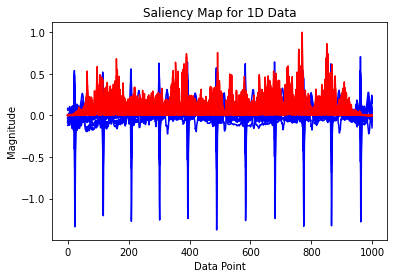

In [287]:

# Plot the saliency map
plt.plot(X[0], color='blue', label='Data')
plt.plot(saliency_map[0], color='red', label='Saliency Map')
plt.xlabel('Data Point')
plt.ylabel('Magnitude')
plt.title('Saliency Map for 1D Data')
plt.show()

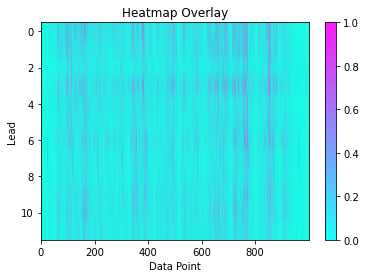

In [296]:
plt.imshow(X[0].T, cmap='hot', aspect='auto')
plt.imshow(saliency_map[0].T, cmap='cool', alpha=0.9, aspect='auto')
plt.colorbar()
plt.xlabel('Data Point')
plt.ylabel('Lead')
plt.title('Heatmap Overlay')
plt.show()


In [262]:
# normalized_gradients = tf.math.abs(gradients)  # Assuming single sample, adjust if necessary
# max_gradient = tf.reduce_max(normalized_gradients)
# normalized_gradients /= max_gradient
# saliency_map = normalized_gradients.numpy()
# gradient_map = np.abs(gradients[0]).mean(axis=1)
# sm = saliency_map[0, :,1].reshape(-1,1)
# saliency_map.shape

(1, 1000, 12)

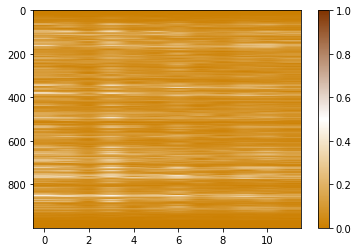

In [268]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.8, 0.5, 0), (1,1,1), (0.5, 0.2,0)]  # Define the desired colors
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
plt.imshow(saliency_map[0], cmap=cmap, aspect = 'auto')
plt.colorbar()
plt.show()

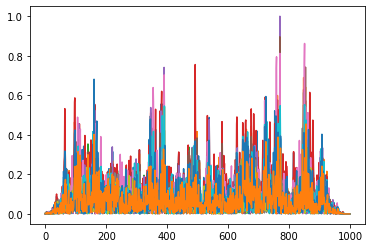

In [264]:
plt.plot(saliency_map[0])
plt.show()